In [1]:
from jax.config import config
config.update('jax_disable_jit', True)


import numpy as np
import jax.numpy as jnp
from jax import grad, vmap, jit, random, jacrev
from jax.lax import while_loop, fori_loop, scan
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
key = random.PRNGKey(0)
import pickle
%matplotlib inline 
# %precision 5
plt.rcParams.update({'font.size': 15})


/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Neural ODE based viscoelasticity in 2D FEM

In [2]:
# Material parameters:
mu_m = np.array([51.4, -18, 3.86])
alpha_m = np.array([1.8, -2, 7])
K_m = 10000
tau = 17.5
shear_mod = 1/2*(mu_m[0]*alpha_m[0] + mu_m[1]*alpha_m[1] + mu_m[2]*alpha_m[2])
eta_D = tau*shear_mod
eta_V = tau*K_m
mu = 77.77 #=shear_mod
K = 10000

@jit
def innerNR(iterables, eps_e_trial, dt, params):
    normres, itr, eps_e = iterables
    
    lamb_e = jnp.exp(eps_e)
    Je = lamb_e[0]*lamb_e[1]*lamb_e[2]
    bbar_e = Je**(-2/3)*lamb_e**2 #(54)

    b1 = bbar_e[0]
    b2 = bbar_e[1]
    b3 = bbar_e[2]

    #Calculate K_AB
    ddev11 = 0
    ddev12 = 0
    ddev13 = 0
    ddev22 = 0
    ddev23 = 0
    ddev33 = 0

    for r in range(3):
        e = alpha_m[r]/2
        ddev11 = ddev11 + mu_m[r]*(2*e)*( 4/9*b1**e + 1/9*(b2**e + b3**e)) #(B12)
        ddev22 = ddev22 + mu_m[r]*(2*e)*( 4/9*b2**e + 1/9*(b1**e + b3**e))
        ddev33 = ddev33 + mu_m[r]*(2*e)*( 4/9*b3**e + 1/9*(b1**e + b2**e))

        ddev12 = ddev12 + mu_m[r]*(2*e)*(-2/9*(b1**e + b2**e) + 1/9*b3**e) #(B13)
        ddev13 = ddev13 + mu_m[r]*(2*e)*(-2/9*(b1**e + b3**e) + 1/9*b2**e)
        ddev23 = ddev23 + mu_m[r]*(2*e)*(-2/9*(b2**e + b3**e) + 1/9*b1**e)
    ddev = jnp.array([[ddev11, ddev12, ddev13],[ddev12, ddev22, ddev23], [ddev13, ddev23, ddev33]])

    K_AB = jnp.eye(3) + dt/2/eta_D*ddev - dt/3/eta_V*K_m*Je**2*jnp.ones([3,3]) #(B15)
    K_AB_inv = jnp.linalg.inv(K_AB)

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
    devtau = jnp.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)

    # Use Neural ODE based approach:
    # tau_A = devtau + 1/3*tau_NEQI #(B8)
    # order = jnp.argsort(-tau_A)

    # d2phid2tau = jnp.array(d2Phi(tau_A[order], params)) #Get the 2nd derivatives of Phi with NODEs

    # dtaui_depsej = ddev + K_m*Je**2
    # dtaui_depsej = dtaui_depsej[order] #-tau_A.argsort sorts descending order which is what I need.

    # K_AB = jnp.eye(3) + dt*jnp.dot(d2phid2tau, dtaui_depsej)
    # K_AB_inv = jnp.linalg.inv(K_AB)
    
    res = eps_e + dt*(1/2/eta_D*devtau + 1/9/eta_V*tau_NEQI*jnp.ones(3))-eps_e_trial #(60)
    deps_e = jnp.dot(K_AB_inv, -res)
    eps_e = eps_e + deps_e
    normres = jnp.linalg.norm(res)
    itr+= 1
    return [normres, itr, eps_e]

@jit
def evalRG(F, C_i_inv, dt, params):
    #Preprocessing
    be_trial = jnp.dot(F, jnp.dot(C_i_inv, F.transpose()))
    lamb_e_trial, n_A = jnp.linalg.eigh(be_trial)
    n_A = jnp.real(n_A)
    lamb_e_trial = jnp.sqrt(jnp.real(lamb_e_trial) + 1.0e-6)
    eps_e_trial = jnp.log(lamb_e_trial + 1.0e-6)
    eps_e = eps_e_trial #Initial guess for eps_e
    
    #Inner Neuton Raphson
    normres = 1.0
    itr = 0
    itermax = 20
    cond_fun = lambda x: jnp.sign(x[0]-1.e-6) + jnp.sign(itermax - x[1]) > 0
    body_fun = lambda iterables: innerNR(iterables, eps_e_trial, dt, params)
    normres, itr, eps_e = while_loop(cond_fun, body_fun, [normres,itr, eps_e])
    lamb_e = jnp.exp(eps_e)
    Je = lamb_e[0]*lamb_e[1]*lamb_e[2]
    bbar_e = Je**(-2/3)*lamb_e**2 #(54)

    b1 = bbar_e[0]
    b2 = bbar_e[1]
    b3 = bbar_e[2]

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))

    devtau = jnp.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQI #(B8)
    tau_NEQ = tau_A[0]*jnp.outer(n_A[:,0], n_A[:,0]) + tau_A[1]*jnp.outer(n_A[:,1], n_A[:,1]) + tau_A[2]*jnp.outer(n_A[:,2], n_A[:,2]) #(58)
    b = jnp.dot(F,F.transpose())
    J = jnp.linalg.det(F)
    sigma_EQ = mu/J*(b-jnp.eye(3)) + 2*K*(J-1)*jnp.eye(3) #neo Hookean material
    sigma = 1/Je*tau_NEQ + sigma_EQ #(7)
    
    #Post processing
    be = jnp.einsum('i,ji,ki->jk', lamb_e**2, n_A, n_A)
    F_inv = jnp.linalg.inv(F)
    C_i_inv_new = jnp.dot(F_inv, jnp.dot(be, F_inv.transpose()))
    return sigma, C_i_inv_new

# def evalRG2(b, dt, params):
#     #Preprocessing
#     be_trial = jnp.copy(b)
#     lamb_e_trial, n_A = jnp.linalg.eigh(be_trial)
#     n_A = jnp.real(n_A)
#     lamb_e_trial = jnp.sqrt(jnp.real(lamb_e_trial) + 1.0e-6)
#     eps_e_trial = jnp.log(lamb_e_trial + 1.0e-6)
#     eps_e = eps_e_trial #Initial guess for eps_e
    
#     #Inner Newton Raphson
#     normres = 1.0
#     itr = 0
#     itermax = 20
#     cond_fun = lambda x: jnp.sign(x[0]-1.e-6) + jnp.sign(itermax - x[1]) > 0
#     body_fun = lambda iterables: innerNR(iterables, eps_e_trial, dt, params)
#     normres, itr, eps_e = while_loop(cond_fun, body_fun, [normres,itr, eps_e])
#     lamb_e = jnp.exp(eps_e)
#     Je = lamb_e[0]*lamb_e[1]*lamb_e[2]
#     bbar_e = Je**(-2/3)*lamb_e**2 #(54)

#     b1 = bbar_e[0]
#     b2 = bbar_e[1]
#     b3 = bbar_e[2]

#     devtau1 = 0
#     devtau2 = 0
#     devtau3 = 0
#     for r in range(3):
#         e = alpha_m[r]/2
#         devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
#         devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
#         devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))

#     devtau = jnp.array([devtau1, devtau2, devtau3])

#     tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
#     tau_A = devtau + 1/3*tau_NEQI #(B8)
#     tau_NEQ = tau_A[0]*jnp.outer(n_A[:,0], n_A[:,0]) + tau_A[1]*jnp.outer(n_A[:,1], n_A[:,1]) + tau_A[2]*jnp.outer(n_A[:,2], n_A[:,2]) #(58)
#     J = jnp.sqrt(jnp.linalg.det(b))
#     sigma_EQ = mu/J*(b-jnp.eye(3)) + 2*K*(J-1)*jnp.eye(3) #neo Hookean material
#     sigma = 1/Je*tau_NEQ + sigma_EQ #(7)
    
#     return sigma

#### Numerically estimate the elasticity tensor, $\mathbb{C}$, for the time being

In [3]:
# def b2sigma2D(b_2D, dt, params):
#     detb = jnp.linalg.det(b_2D)
#     b = jnp.array([[b_2D[0,0], b_2D[0,1], 0],
#                    [b_2D[1,0], b_2D[1,1], 0],
#                    [0,         0,      1.0/detb]])
#     sigma = evalRG2(b, dt, params)
#     return sigma[:2,:2]

# @jit
# def eval_cc(b_2D, dt, params):
#     dsigmadb = []
#     epsilon = 1.e-3
#     for i in range(2):
#         for j in range(2):
#             b_p = jnp.array(b_2D)
#             b_m = jnp.array(b_2D)
#             b_p = b_p.at[i,j].set(b_2D[i,j]+epsilon)
#             b_p = b_p.at[j,i].set(b_2D[j,i]+epsilon)
#             b_m = b_m.at[i,j].set(b_2D[i,j]-epsilon)
#             b_m = b_m.at[j,i].set(b_2D[j,i]-epsilon)
            
#             sigma_p = b2sigma2D(b_p, dt, params)
#             sigma_m = b2sigma2D(b_m, dt, params)
#             dsigmadb.append((sigma_p-sigma_m)/(4*epsilon))
#     dsigmadb = jnp.array(dsigmadb).reshape([2,2,2,2])
#     return 2*dsigmadb

In [4]:
# def evalRG_REF(C, F, dt, params):
#     #Preprocessing
#     Ce_trial = jnp.copy(C)
#     lamb_e_trial, N_A = jnp.linalg.eigh(Ce_trial)
#     lamb_e_trial = jnp.sqrt(jnp.real(lamb_e_trial) + 1.0e-6)
#     N_A = jnp.real(N_A)

#     # RU decomposition of F
#     U = jnp.array([[lamb_e_trial[0], 0, 0],
#                   [0, lamb_e_trial[1], 0],
#                   [0, 0, lamb_e_trial[2]]])
#     Q = jnp.copy(N_A)
#     U = jnp.einsum('ij,jk,kl->il', Q.T, U, Q)
#     R = jnp.dot(F, jnp.linalg.inv(U))
#     n_A = jnp.dot(R, N_A)

#     eps_e_trial = jnp.log(lamb_e_trial + 1.0e-6)
#     eps_e = eps_e_trial #Initial guess for eps_e
    
#     #Inner Newton Raphson
#     normres = 1.0
#     itr = 0
#     itermax = 20
#     cond_fun = lambda x: jnp.sign(x[0]-1.e-6) + jnp.sign(itermax - x[1]) > 0
#     body_fun = lambda iterables: innerNR(iterables, eps_e_trial, dt, params)
#     normres, itr, eps_e = while_loop(cond_fun, body_fun, [normres,itr, eps_e])
#     lamb_e = jnp.exp(eps_e)
#     Je = lamb_e[0]*lamb_e[1]*lamb_e[2]
#     bbar_e = Je**(-2/3)*lamb_e**2 #(54)

#     b1 = bbar_e[0]
#     b2 = bbar_e[1]
#     b3 = bbar_e[2]

#     devtau1 = 0
#     devtau2 = 0
#     devtau3 = 0
#     for r in range(3):
#         e = alpha_m[r]/2
#         devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
#         devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
#         devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))

#     devtau = jnp.array([devtau1, devtau2, devtau3])

#     tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
#     tau_A = devtau + 1/3*tau_NEQI #(B8)
#     tau_NEQ = tau_A[0]*jnp.outer(n_A[:,0], n_A[:,0]) + tau_A[1]*jnp.outer(n_A[:,1], n_A[:,1]) + tau_A[2]*jnp.outer(n_A[:,2], n_A[:,2]) #(58)
#     J = jnp.sqrt(jnp.linalg.det(C))
#     S_EQ = mu/J*(jnp.eye(3) - jnp.linalg.inv(C)) + 2*K*(J-1)*jnp.linalg.inv(C)
#     S_NEQ = jnp.einsum('ij,jk,kl->il', jnp.linalg.inv(F), 1/Je*tau_NEQ, jnp.linalg.inv(F.T))/J

#     return S_EQ + S_NEQ


# def solve3D(C_2D, F_2D, dt, params):
#     C_33 = jnp.linalg.det(C_2D) #initial guess
#     F_33 = jnp.linalg.det(F_2D)
#     def f(aux):
#         C_33, F_33 = aux
#         C = jnp.array([[C_2D[0,0], C_2D[0,1], 0],
#                        [C_2D[1,0], C_2D[1,1], 0],
#                        [0,         0,      C_33]])
#         F = jnp.array([[F_2D[0,0], F_2D[0,1], 0],
#                        [F_2D[1,0], F_2D[1,1], 0],
#                        [0,         0,      F_33]])
#         S33 = evalRG_REF(C, F, dt, params)[2,2]
#         return S33
#     def f_pr(aux):
#         C_33, F_33 = aux
#         epsilon = 1.e-3

#         # Derivative wrt C_33
#         C_33_p = C_33 + epsilon
#         C_33_m = C_33 - epsilon

#         C_p = jnp.array([[C_2D[0,0], C_2D[0,1], 0],
#                          [C_2D[1,0], C_2D[1,1], 0],
#                          [0,         0,    C_33_p]])
#         C_m = jnp.array([[C_2D[0,0], C_2D[0,1], 0],
#                          [C_2D[1,0], C_2D[1,1], 0],
#                          [0,         0,    C_33_m]])
#         F = jnp.array([[F_2D[0,0], F_2D[0,1], 0],
#                        [F_2D[1,0], F_2D[1,1], 0],
#                        [0,         0,      F_33]])
#         S_33_p = evalRG_REF(C_p, F, dt, params)[2,2]
#         S_33_m = evalRG_REF(C_m, F, dt, params)[2,2]

#         dS33dC33 = (S_33_p-S_33_m)/2.0/epsilon

#         # Derivative wrt F_33
#         F_33_p = F_33 + epsilon
#         F_33_m = F_33 - epsilon
#         F_p = jnp.array([[F_2D[0,0], F_2D[0,1], 0],
#                          [F_2D[1,0], F_2D[1,1], 0],
#                          [0,         0,    F_33_p]])
#         F_m = jnp.array([[F_2D[0,0], F_2D[0,1], 0],
#                          [F_2D[1,0], F_2D[1,1], 0],
#                          [0,         0,    F_33_m]])
#         C = jnp.array([[C_2D[0,0], C_2D[0,1], 0],
#                        [C_2D[1,0], C_2D[1,1], 0],
#                        [0,         0,      C_33]])
#         S_33_p = evalRG_REF(C, F_p, dt, params)[2,2]
#         S_33_m = evalRG_REF(C, F_m, dt, params)[2,2]
#         dS33dF33 = (S_33_p-S_33_m)/2.0/epsilon
#         return [dS33dC33, dS33dF33]

#     n_step = 20
#     def body_fun(aux, x):
#         d1, d2 = f_pr(aux)
#         upd1 = aux[0]
#         upd2 = aux[1]
#         if d1 != 0:
#             upd1 = aux[0] - f(aux)/d1
#         if d2 != 0:
#             upd2 = aux[1] - f(aux)/d2
#         return [upd1, upd2], x
#     [C_33, F_33], _ = scan(body_fun, [C_33, F_33], xs = None, length=n_step)
#     return C_33, F_33

# def eval_CC(C_2D, F_2D, dt, params):
#     C_33, F_33 = solve3D(C_2D, F_2D, dt, params)
#     C = jnp.array([[C_2D[0,0], C_2D[0,1], 0],
#                    [C_2D[1,0], C_2D[1,1], 0],
#                    [0,         0,      C_33]])
#     F = jnp.array([[F_2D[0,0], F_2D[0,1], 0],
#                    [F_2D[1,0], F_2D[1,1], 0],
#                    [0,         0,      F_33]])
#     dSdC = []
#     epsilon = 1.e-3
#     for i in range(2):
#         for j in range(2):
#             C_p = jnp.array(C)
#             C_m = jnp.array(C)
#             C_p = C_p.at[i,j].set(C[i,j]+epsilon)
#             C_p = C_p.at[j,i].set(C[j,i]+epsilon)
#             C_m = C_m.at[i,j].set(C[i,j]-epsilon)
#             C_m = C_m.at[j,i].set(C[j,i]-epsilon)
            
#             S_p = evalRG_REF(C_p, F, dt, params)[:2,:2]
#             S_m = evalRG_REF(C_m, F, dt, params)[:2,:2]
#             dSdC.append((S_p-S_m)/(4*epsilon))
#     dSdC = jnp.array(dSdC).reshape([2,2,2,2])
#     return 2*dSdC

# Finite Element Method

In [5]:
#Generate nodes and elements
n_node = 25
n_elem = int((np.sqrt(n_node)-1))**2
node_X, node_Y = np.meshgrid(np.linspace(0,1,5),np.linspace(0,1,5))
node_X = np.vstack((node_Y.flatten(), node_X.flatten())).T

elements = np.zeros((n_elem, 4), dtype=np.int8)

i=0
j=0
while i < n_node - 5:
    if i == 0 or (i+1)%5 != 0:
        elements[j,0] = i
        elements[j,3] = i+1
        elements[j,2] = i+6
        elements[j,1] = i+5
        j+= 1
    i+= 1

Text(0.5, 1.0, 'Undeformed Mesh')

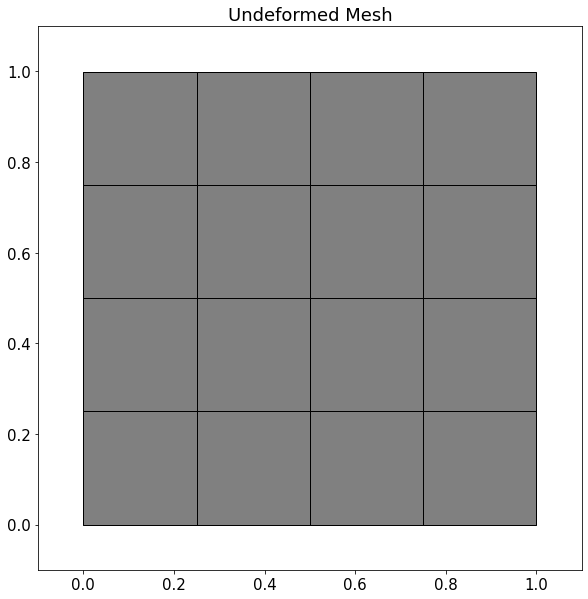

In [6]:
# plot mesh to check
## Plot the mesh 
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
ax.set_aspect('equal')
patches = []
#viridis = matplotlib.cm.get_cmap('viridis', 50)
colors = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_X[n1],node_X[n2],node_X[n3],node_X[n4]], edgecolor='r', facecolor=None, closed=True)
    patches.append(polygon)
    colors[i] = np.random.rand()
p = PatchCollection(patches, edgecolor='k', facecolor='gray')
#p.set_array(colors)
ax.add_collection(p)
ax.set_title("Undeformed Mesh")
# fig.savefig('Figures/FEM/undeformed.jpg', dpi=400, bbox_inches='tight')

In [7]:
# Shape functions and derivatives 

def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])
                          

## Compute the element residual and tangent and assemble into global residual and tangent



In [8]:
# putting it inside a function
def assembleRRKK(dt, Ciinv):
    Ciinvnew = np.zeros_like(Ciinv)
    # assemble total residual 
    RR = np.zeros(n_node*2)
    # assemble the total tangent 
    KK = np.zeros((n_node*2,n_node*2))
    # loop over elements
    for ei in range(n_elem):
        # initialize the residual for this element
        Re = np.zeros((8))
        # initialize the tangent for this element
        Ke = np.zeros((8,8))

        # nodes that make up this element 
        node_ei = elements[ei]
        # reference coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_X_ei = np.zeros((4,2))
        # deformed coordinates of the nodes making up this element (init to zero, fill in a loop)
        node_x_ei = np.zeros((4,2))
        for ni in range(4):
            node_X_ei[ni] = node_X[node_ei[ni]]
            node_x_ei[ni] = node_x[node_ei[ni]]
            
        IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                          [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
        IP_wi = np.array([1.,1.,1.,1.])
        for ip in range(4):
            xi  = IP_xi[ip,0]
            eta = IP_xi[ip,1]
            wi = IP_wi[ip]
            # eval shape functions 
            Ns = Nvec(xi,eta)
            # eval the isoparametric map for the reference and deformed points corresponding to xi,eta = 0
            X = np.zeros((2))
            x = np.zeros((2))
            for ni in range(4):
                X += Ns[ni]*node_X_ei[ni]
                x += Ns[ni]*node_x_ei[ni]

            # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
            dNsdxi = dNvecdxi(xi,eta)
            dXdxi = np.zeros((2,2))
            dxdxi = np.zeros((2,2))
            for ni in range(4):
                dXdxi += np.outer(node_X_ei[ni],dNsdxi[:,ni])
                dxdxi += np.outer(node_x_ei[ni],dNsdxi[:,ni])
            # get gradient of basis function with respect to X using inverse jacobian 
            JinvT = np.linalg.inv(dXdxi).transpose()
            dNsdX = np.dot(JinvT,dNsdxi)

            # get gradient of basis function with respect to x using inverse jacobian, the other one 
            jinvT = np.linalg.inv(dxdxi).transpose()
            dNsdx = np.dot(jinvT,dNsdxi)

            # get the deformation gradient 
            F = np.zeros((2,2))
            for ni in range(4):
                F += np.outer(node_x_ei[ni],dNsdX[:,ni])
            detF = np.linalg.det(F)
            ################ Stress ####################
            params = []
            
            F_3D = np.array([[F[0,0], F[0,1], 0],
                             [F[1,0], F[1,1], 0],
                             [0,   0,  1.0/detF]])
            sigma, Ciinv_new = evalRG(F_3D, Ciinv[ei,ip], dt, params)
            Ciinvnew[ei,ip] = Ciinv_new
            sigma = sigma[:2,:2]
            
            # compute the variation of the symmetric velocity gradient by moving one node and one component
            # of that node at a time, except if the node is on the boundary in which case no variation is allowed
            for ni in range(4):
                for ci in range(2):
                    deltav = np.zeros((2))
                    # note, no worries about the boundary because we will get rid of the corresponding rows
                    # of the residual because they wont be zero 
                    deltav[ci] = 1
                    gradx_v = np.outer(deltav,dNsdx[:,ni])
                    deltad = 0.5*(gradx_v + gradx_v.transpose())
                    Re[ni*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)

                    RR[node_ei[ni]*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)

    
    #===================================================================================================================
    # evaluate the entire KK numerically
    #===================================================================================================================
    for nj in range(n_node):
        for cj in range(2):
            node_x_p = np.copy(node_x)
            eps = 1.e-3
            node_x_p[nj,cj]+= eps
            RR_p = np.zeros(n_node*2)
            
            for ei in range(n_elem):
                node_ei = elements[ei]
                node_X_ei = np.zeros((4,2))
                node_x_ei = np.zeros((4,2))
                for ni in range(4):
                    node_X_ei[ni] = node_X[node_ei[ni]]
                    node_x_ei[ni] = node_x_p[node_ei[ni]]
                IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                                [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
                IP_wi = np.array([1.,1.,1.,1.])
                for ip in range(4):
                    xi  = IP_xi[ip,0]
                    eta = IP_xi[ip,1]
                    wi = IP_wi[ip]
                    # eval shape functions 
                    Ns = Nvec(xi,eta)
                    # eval the isoparametric map for the reference and deformed points corresponding to xi,eta = 0
                    X = np.zeros((2))
                    x = np.zeros((2))
                    for ni in range(4):
                        X += Ns[ni]*node_X_ei[ni]
                        x += Ns[ni]*node_x_ei[ni]

                    # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
                    dNsdxi = dNvecdxi(xi,eta)
                    dXdxi = np.zeros((2,2))
                    dxdxi = np.zeros((2,2))
                    for ni in range(4):
                        dXdxi += np.outer(node_X_ei[ni],dNsdxi[:,ni])
                        dxdxi += np.outer(node_x_ei[ni],dNsdxi[:,ni])
                    # get gradient of basis function with respect to X using inverse jacobian 
                    JinvT = np.linalg.inv(dXdxi).transpose()
                    dNsdX = np.dot(JinvT,dNsdxi)

                    # get gradient of basis function with respect to x using inverse jacobian, the other one 
                    jinvT = np.linalg.inv(dxdxi).transpose()
                    dNsdx = np.dot(jinvT,dNsdxi)

                    # get the deformation gradient 
                    F = np.zeros((2,2))
                    for ni in range(4):
                        F += np.outer(node_x_ei[ni],dNsdX[:,ni])
                    detF = np.linalg.det(F)
                    ################ Stress ####################
                    params = []
                    F_3D = np.array([[F[0,0], F[0,1], 0],
                                     [F[1,0], F[1,1], 0],
                                     [0,   0,  1.0/detF]])
                    sigma, Ciinv_new = evalRG(F_3D, Ciinv[ei,ip], dt, params)
                    sigma = sigma[:2,:2]
                    
                    # compute the variation of the symmetric velocity gradient by moving one node and one component
                    # of that node at a time, except if the node is on the boundary in which case no variation is allowed
                    for ni in range(4):
                        for ci in range(2):
                            deltav = np.zeros((2))
                            # note, no worries about the boundary because we will get rid of the corresponding rows
                            # of the residual because they wont be zero 
                            deltav[ci] = 1
                            gradx_v = np.outer(deltav,dNsdx[:,ni])
                            deltad = 0.5*(gradx_v + gradx_v.transpose())
                            Re[ni*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)

                            RR_p[node_ei[ni]*2+ci] += wi*np.linalg.det(dxdxi)*np.tensordot(sigma,deltad)
            for ni in range(4):
                for ci in range(2):
                    KK[nj*2+cj, node_ei[ni]*2+ci] += (RR_p[node_ei[ni]*2+ci] - RR[node_ei[ni]*2+ci])/eps

                    # ## 2 more for loops for the increment Delta u
                    # for nj in range(4):
                    #     for cj in range(2):
                    #         Deltau = np.zeros((2))
                    #         Deltau[cj]=1
                    #         gradx_Du = np.outer(Deltau,dNsdx[:,nj])
                    #         Deltaeps = 0.5*(gradx_Du + gradx_Du.transpose())
                            
                    #         ## ELEMENT TANGENT
                    #         # Initial stress component (also called geometric component) is 
                    #         # sigma: (gradDeltau^T gradv)
                    #         Kgeom = np.tensordot(sigma,np.dot(gradx_Du.transpose(),gradx_v))
                    #         # Material component, need to put things in voigt notation for easy computation
                    #         deltad_voigt = np.array([deltad[0,0],deltad[1,1],2*deltad[0,1]])
                    #         Deltaeps_voigt = np.array([Deltaeps[0,0],Deltaeps[1,1],2*Deltaeps[0,1]])
                            
                            
                    #         ################ Elastic Moduli ####################
                    #         CC = eval_CC(C, F)
                    #         cc = np.einsum('ij,kl,mn,op,jlnp->ikmo', F, F, F, F, CC)
                    #         D = np.zeros((3,3))
                    #         Itoi = [0,1,0]
                    #         Itoj = [0,1,1]
                    #         for I in range(3):
                    #             for J in range(3):
                    #                 i = Itoi[I]
                    #                 j = Itoj[I]
                    #                 k = Itoi[J]
                    #                 l = Itoj[J]
                    #                 D[I,J] = cc[i,j,k,l] #D: cc in voigt notation
                            
                    #         #D = np.array([[4*p,2*p,0],[2*p,4*p,0],[0,0,2*p]])
                    #         Kmat = np.dot(Deltaeps_voigt,np.dot(D,deltad_voigt))
                    #         # add to the corresponding entry in Ke and dont forget other parts of integral
                    #         Ke[ni*2+ci,nj*2+cj] += wi*np.linalg.det(dxdxi)*(Kgeom+Kmat)
                    #         # assemble into global 
                    #         KK[node_ei[ni]*2+ci,node_ei[nj]*2+cj] += wi*np.linalg.det(dxdxi)*(Kgeom+Kmat)
#         print(F)
#         print(D)
#         print(sigma)
#         print('--------')
                            
    return RR,KK,Ciinvnew

In [9]:
def commonformat(ax):
    for b in ax:
        for a in b:
            a.set(xlim=[-0.1,1.2], ylim=[-0.1, 1.3], aspect='equal')
            a.spines['top'].set_visible(False)
            a.spines['right'].set_visible(False)
            a.spines['bottom'].set_visible(False)
            a.spines['left'].set_visible(False)
    return

def plot_stress(mode = 'uni'):
    plt.rcParams.update({'font.sans-serif':'Arial'})
    fig, ax = plt.subplots(1, 2, figsize=(14,21))
    patches = []
    colors = np.zeros((2,n_elem))
    
    for i in range(n_elem):
        n1 = elements[i,0]
        n2 = elements[i,1]
        n3 = elements[i,2]
        n4 = elements[i,3]
        polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
        patches.append(polygon)
        # compute stress at center 
        xi  = 0
        eta = 0
        # evaluate the Jacobians, first derivative of shape functions with respect to xi space then Jacobians 
        dNsdxi = dNvecdxi(xi,eta)
        dXdxi = np.outer(node_X[n1],dNsdxi[:,0])+np.outer(node_X[n2],dNsdxi[:,1])\
                +np.outer(node_X[n3],dNsdxi[:,2])+np.outer(node_X[n4],dNsdxi[:,3])
        # get gradient of basis function with respect to X using inverse jacobian 
        JinvT = np.linalg.inv(dXdxi).transpose()
        dNsdX = np.dot(JinvT,dNsdxi)
        # get the deformation gradient 
        F = np.outer(node_x[n1],dNsdX[:,0])+np.outer(node_x[n2],dNsdX[:,1])\
            +np.outer(node_x[n3],dNsdX[:,2])+np.outer(node_x[n4],dNsdX[:,3])

        sigma = sig(F)
        colors[0,i] = sigma[0,0]*1000
        colors[1,i] = sigma[1,1]*1000
        
        
    for i in range(2):
        p = PatchCollection(patches, edgecolor='k')
        p.set_array(colors[i])
        p.set_cmap('Blues')
        p.set_clim([np.min(colors[i]),np.max(colors[i])])
        imap = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]]
        labelmap = ['$\sigma_{xx}$ [kPa]', '$\sigma_{yy}$ [kPa]']
        ax[imap[i][0], imap[i][1]].add_collection(p)
        plt.colorbar(p,ax=ax[imap[i][0], imap[i][1]], label=labelmap[i], fraction = 0.03)
        
    commonformat(ax)
    return fig, ax

# Uniaxial Tension

In [10]:
dt = 0.1 # hr
n_steps = 10
Ciinvvector = np.zeros((n_elem,4,3,3)) # a 3x3 array for every integration point of every array.
Ciinvvector_prev = np.zeros((n_elem,4,3,3))
for i in range(n_elem):
    for j in range(4):
        Ciinvvector[i,j] = np.eye(3)
        Ciinvvector_prev[i,j] = np.eye(3)


node_x = np.zeros_like(node_X)
DOF_fmap = np.zeros((n_node,2),dtype=int)
DOF_imap = [] 
dof = 0
for i in range(n_node):
    X = node_X[i]
    node_x[i] = node_X[i]
    if X[0]<0.001:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 0
        if X[1] < 0.001:
            DOF_fmap[i,1] = -1
            node_x[i,1] = 0
        else:
            DOF_fmap[i,1] = dof
            DOF_imap.append([i,0])
            dof+= 1
    elif X[0]>0.999:
        DOF_fmap[i,0] = -1
        node_x[i,0] = 1.0
        DOF_fmap[i,1] = dof
        DOF_imap.append([i,1])
        dof+= 1
    else:
        DOF_fmap[i,0] = dof
        DOF_fmap[i,1] = dof+1
        dof+=2 
        DOF_imap.append([i,0])
        DOF_imap.append([i,1])
        

for ti in range(n_steps):
    t = ti*dt

    # Update the node_x array for each time step
    for i in range(n_node):
        X = node_X[i]
        if X[0]>0.9999: 
            node_x[i,0] = 1.0 + 0.1*t
        # if X[1]>0.9999: 
        #     node_x[i,1] = 1.0 + 0.1*t

    res = 5
    iter = 0
    tol = 1e-5
    itermax = 10
    while res>tol and iter<itermax:
        RR,KK, TempCiinv = assembleRRKK(dt, Ciinvvector_prev)
        # for the increment not all of the KK is needed because some nodes have essential BC
        RRdof = RR[DOF_fmap.flatten()>=0]
        KKdof = KK[DOF_fmap.flatten()>=0]
        KKdof = KKdof[:,DOF_fmap.flatten()>=0]
        res = np.linalg.norm(RRdof)
        incr_u = -np.linalg.solve(KKdof,RRdof)
        j = 0
        for i in range(n_node):
            if DOF_fmap[i,0] >= 0:
                node_x[i,0]+= incr_u[j]
                j+= 1
            if DOF_fmap[i,1] >= 0:
                node_x[i,1]+= incr_u[j] 
                j+= 1
        iter +=1
        if iter%1 == 0:
            print('iter %i'%iter)
            print(res)

LinAlgError: Singular matrix

In [ ]:
# plot_stress('uni')
# # with open('FEM_data/uni_coarse.dat' , 'wb') as f:
# #     pickle.dump(node_x, f)

# Shearing

In [ ]:
# node_x = np.zeros_like(node_X)
# DOF_fmap = np.zeros((n_node,2),dtype=int)
# DOF_imap = [] 
# dof = 0
# for i in range(n_node):
#     X = node_X[i]
#     node_x[i] = node_X[i]
#     if X[0]<0.001:
#         DOF_fmap[i,0] = -1
#         node_x[i,0] = 0
#         DOF_fmap[i,1] = -1
#     elif X[0]>0.999:
#         DOF_fmap[i,0] = -1
#         node_x[i,0] = 1.1
#         DOF_fmap[i,1] = -1
#         node_x[i,1] = node_x[i,1] + 0.1
#     else:
#         DOF_fmap[i,0] = dof
#         DOF_fmap[i,1] = dof+1
#         dof+=2 
#         DOF_imap.append([i,0])
#         DOF_imap.append([i,1])
        
# ## Newton Raphson 
# res = 5
# iter = 0
# tol = 1e-5
# itermax = 10
# while res>tol and iter<itermax:
#     RR,KK = assembleRRKK()
#     # for the increment not all of the KK is needed because some nodes have essential BC
#     RRdof = RR[DOF_fmap.flatten()>=0]
#     KKdof = KK[DOF_fmap.flatten()>=0]
#     KKdof = KKdof[:,DOF_fmap.flatten()>=0]
#     res = np.linalg.norm(RRdof)
#     incr_u = -np.linalg.solve(KKdof,RRdof)
#     j = 0
#     for i in range(n_node):
#         if DOF_fmap[i,0] >= 0:
#             node_x[i,0]+= incr_u[j]
#             j+= 1
#         if DOF_fmap[i,1] >= 0:
#             node_x[i,1]+= incr_u[j]
#             j+= 1
#     iter +=1
#     if iter%5 == 0:
#         print('iter %i'%iter)
#         print(res)

In [ ]:
# plot_stress('she')
# # with open('FEM_data/she_coarse.dat' , 'wb') as f:
# #     pickle.dump(node_x, f)

# Clamped Uniaxial Tension

In [ ]:
# node_x = np.zeros_like(node_X)
# DOF_fmap = np.zeros((n_node,2),dtype=int)
# DOF_imap = [] 
# dof = 0
# for i in range(n_node):
#     X = node_X[i]
#     node_x[i] = node_X[i]
#     if X[0]<0.001:
#         DOF_fmap[i,0] = -1
#         DOF_fmap[i,1] = -1
#     elif X[0]>0.999:
#         DOF_fmap[i,0] = -1
#         node_x[i,0] = 1.1
#         DOF_fmap[i,1] = dof
#         DOF_imap.append([i,1])
#         dof+= 1
#         #DOF_fmap[i,1] = -1
#         #node_x[i,1] = node_x[i,1] + 0.1
#     else:
#         DOF_fmap[i,0] = dof
#         DOF_fmap[i,1] = dof+1
#         dof+=2 
#         DOF_imap.append([i,0])
#         DOF_imap.append([i,1])
        
# ## Newton Raphson 
# res = 5
# iter = 0
# tol = 1e-5
# itermax = 10
# while res>tol and iter<itermax:
#     RR,KK = assembleRRKK()
#     # for the increment not all of the KK is needed because some nodes have essential BC
#     RRdof = RR[DOF_fmap.flatten()>=0]
#     KKdof = KK[DOF_fmap.flatten()>=0]
#     KKdof = KKdof[:,DOF_fmap.flatten()>=0]
#     res = np.linalg.norm(RRdof)
#     incr_u = -np.linalg.solve(KKdof,RRdof)
#     j = 0
#     for i in range(n_node):
#         if DOF_fmap[i,0] >= 0:
#             node_x[i,0]+= incr_u[j]
#             j+= 1
#         if DOF_fmap[i,1] >= 0:
#             node_x[i,1]+= incr_u[j]
#             j+= 1
#     iter +=1
#     if iter%5 == 0:
#         print('iter %i'%iter)
#         print(res)

In [ ]:
# plot_stress('tor')
# with open('FEM_data/tor_coarse.dat' , 'wb') as f:
#     pickle.dump(node_x, f)